In [1]:
using JLD2
using FileIO
using PyPlot
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using HDF5
using KernelDensity
using IntervalSets
using Random, ArraysOfArrays
using ValueShapes
using Measurements
using BAT
using DSP
using ForwardDiff

In [2]:
n_events = 35
n_cameras = 3

prior_ang = NamedTupleDist(
    θ = [10^-20 .. 10^-4 for i in 1:n_events],
    α = [0 .. 2*pi  for i in 1:n_events],
    x0 = [-5 .. 5 for i in 1:n_cameras],
    y0 = [-5 .. 5 for i in 1:n_cameras],
    σ_x = [10^-11 .. 0.2 for i in 1:n_cameras],
    σ_y = [10^-11 .. 0.2 for i in 1:n_cameras],
);

In [3]:
function hist_1d(samples, dim_1, nbins)
    smpl_tmp, smpl_w = flatview(unshaped.(samples.v)), samples.weight
    hist_v = fit(Histogram, smpl_tmp[dim_1,:], FrequencyWeights(round.(Int64, smpl_w)), nbins)
    hist_v = normalize(hist_v, mode=:pdf)
    return hist_v
end

function hist_1d_log(samples, dim_1, nbins)
    smpl_tmp, smpl_w = flatview(unshaped.(samples.v)), samples.weight
    hist_v = fit(Histogram, log.(smpl_tmp[dim_1,:]), FrequencyWeights(round.(Int64, smpl_w)), nbins)
    hist_v = normalize(hist_v, mode=:pdf)
    return hist_v
end

hist_1d_log (generic function with 1 method)

In [4]:
@load "../../data/sampling_results/Benchmark-5/alignment/lc-data.jld2" data fit_par_values

2-element Array{Symbol,1}:
 :data
 :fit_par_values

In [5]:
fit_par_values[1]

(θ = [3.810311221409573e-6, 4.874668619154936e-6, 1.2723030489949665e-6, 1.4730112547866368e-6, 1.931737761902975e-6, 1.1151300145406649e-6, 3.75481915125512e-7, 2.036983570858537e-6, 2.1404247015236896e-6, 1.313353900966594e-6  …  4.993525549068069e-6, 5.7734070057913545e-6, 1.5829945245398083e-6, 1.440438620853754e-6, 9.443493998309782e-7, 5.321219852391566e-6, 6.422192610354442e-7, 3.4724754705351537e-7, 1.3966497576864415e-5, 2.3749459727985422e-6], α = [0.061977463257672526, 3.130723949460696, 2.8515534648975374, 6.269090750677613, 1.2269768490237627, 1.3578854918145558, 2.82111001974541, 2.5762923191628335, 1.6093737735078697, 0.13288036318662427  …  1.5721651898746567, 0.7583134384556466, 5.221263471629342, 1.7990628203329506, 3.5057024408520188, 3.2749818182842834, 0.19857213703303236, 2.8692677334220775, 3.1303408247375764, 2.8734587368296447], x0 = [-0.17135606286170116, 1.5056514283070621, 3.4533918465950135], y0 = [-0.24182898387146343, 1.4493433067144061, 3.020318244479501

In [6]:
smpl = bat_read("../../data/sampling_results/Benchmark-5/alignment/lc-samples.hdf5")
smpl = varshape(prior_ang).(smpl);

In [7]:
smpl_flat, smpl_w = flatview(unshaped.(smpl.v)), smpl.weight;

In [8]:
# az_angles = log.(mode(smpl).θ)
 az_angles = log.(fit_par_values[1].θ)

az_angles = az_angles .- minimum(az_angles)
az_angles = az_angles ./ maximum(az_angles)
legend_tmp = log.(fit_par_values[1].θ);

In [9]:
nbins = range(0, stop=2*pi, length=250)
hist_array = [hist_1d(smpl, i, nbins) for i in n_events+1:2*n_events];

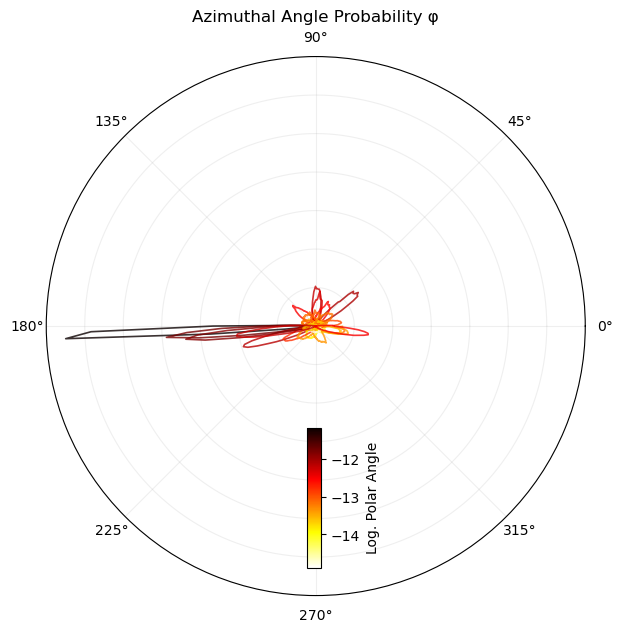

PyObject Text(0.5, 1.05, 'Azimuthal Angle Probability φ')

In [78]:
fig = figure(figsize=(7,7))

ax = PyPlot.axes(polar="true") # Create a polar axis

for i in eachindex(hist_array)[end:-1:1]
    ax.plot(midpoints(hist_array[i].edges[1]), 
        hist_array[i].weights, 
        lw=1.2,  "o-", 
        color= plt.cm.hot_r(az_angles[i]), 
        alpha=0.8, 
        marker="None") 
end

cb = ax.scatter(az_angles, az_angles, lw=0.0,  s=0.0, c=legend_tmp, cmap="hot_r")
ax_ins_3 = fig.add_axes([0.5,0.15,0.02,0.2])
fig.colorbar(cb, spacing="proportional", label="Log. Polar Angle", cax=ax_ins_3)

#color=plt.cm.Spectral(i/length(hist_array))
ax.grid(alpha=0.2)
# ax.set_ylabel("")
ax.set_yticklabels([])
ax.set_ylim(0, 14)
ax.set_title("Azimuthal Angle Probability φ")

In [11]:
nbins_2 = range(-20, stop=-10, length=200)
hist_array_2 = [hist_1d_log(smpl, i, nbins_2) for i in 1:n_events];

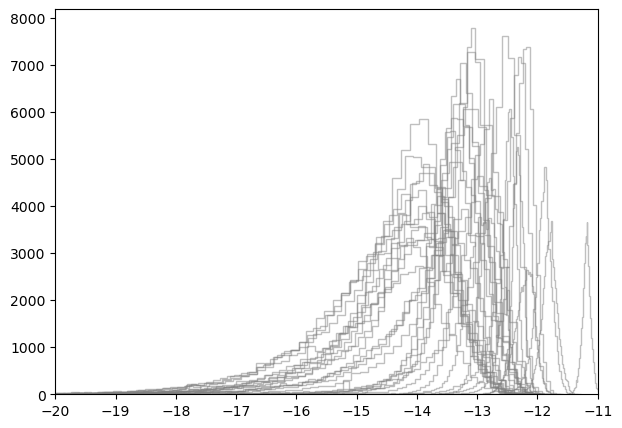

(-20.0, -11.0)

In [12]:
fig, ax= plt.subplots(1,1, figsize=(7,5), )

for i in eachindex(hist_array)
    ax.hist(log.(smpl_flat[i,:]), weights=smpl_w, 100, histtype = "step", color="gray", alpha=0.5)
end
ax.set_xlim(-20, -11)


In [105]:
function plot_lines(mpar, data, smax)
    
    fig = plt.figure(figsize=(11,5))
    ax = fig.add_subplot(111, projection="3d")
    
    x_min = minimum([i[1] for i in data.x_event])
    y_min = minimum([i[1] for i in data.y_event])

    for i in eachindex(hist_array)[end:-1:1]

        x_expected = cos(mpar.α[i])*tan(mpar.θ[i])*smax*10^3
        y_expected = sin(mpar.α[i])*tan(mpar.θ[i])*smax*10^3

        x = [data.x_event[i][1] - x_min, data.x_event[i][1] - y_min  + x_expected]*1000
        y = [data.y_event[i][1] - y_min, data.y_event[i][1] - y_min  + y_expected]*1000
        z = [0.0, data.s_cam[end]]

        ax.plot(z, x, y,
            lw=1.2,
            color= plt.cm.hot_r(az_angles[i]), 
            "o-", 
            alpha=0.8, 
        ) 
    end
    
#     cb = ax.scatter(az_angles, az_angles, lw=0.0,  s=0.0, c=legend_tmp, cmap="hot_r")
#     ax_ins_3 = fig.add_axes([0.5,0.15,0.02,0.2])
#     fig.colorbar(cb, spacing="proportional", label="Log. Polar Angle", cax=ax_ins_3)


    ax.set_xlabel("Beamline (m)")
    ax.set_ylabel(L"\mu_x \; (μm)")
    ax.set_zlabel(L"\mu_y \; (μm)")
    
end

plot_lines (generic function with 2 methods)

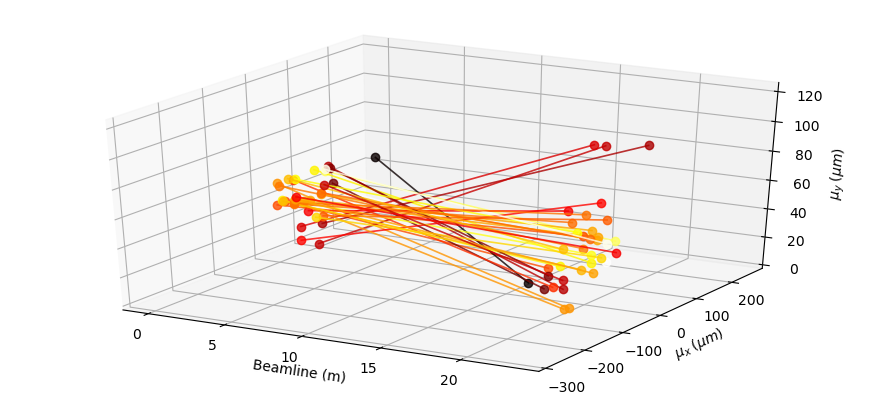

PyObject Text(0.08477726976060036, 0.011358000484434042, '$\\mu_y \\; (μm)$')

In [106]:
plot_lines(fit_par_values[1], data, 24)

In [124]:
x_array = [i[1] for i in data.x_event]
y_array = [i[1] for i in data.y_event]
θ_array = fit_par_values[1].θ
α_array = fit_par_values[1].α

35-element Array{Float64,1}:
 0.061977463257672526
 3.130723949460696
 2.8515534648975374
 6.269090750677613
 1.2269768490237627
 1.3578854918145558
 2.82111001974541
 2.5762923191628335
 1.6093737735078697
 0.13288036318662427
 1.9910933561038786
 3.5611112383533685
 2.126012022216004
 ⋮
 3.1291567611221023
 1.44373053650078
 1.5721651898746567
 0.7583134384556466
 5.221263471629342
 1.7990628203329506
 3.5057024408520188
 3.2749818182842834
 0.19857213703303236
 2.8692677334220775
 3.1303408247375764
 2.8734587368296447